<center><h1>Breast-Cancer-Classification</h1></center>

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

Import packages

In [26]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

In [27]:
# 1(a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set
filepath = '../data/wdbc.data'
column_names = ['ID', 'Diagnosis'] + [f'Feature_{i}' for i in range(1, 31)]
data = pd.read_csv(filepath, header=None, names=column_names)

# Convert diagnosis to binary (M=1, B=0)
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

# Separate features and target
X = data.iloc[:, 2:].values
y = data['Diagnosis'].values

display(data.head())
# Display basic information
print(f"Dataset shape: {X.shape}")
print(f"Number of positive samples: {np.sum(y == 1)}")
print(f"Number of negative samples: {np.sum(y == 0)}")

,ID,Diagnosis,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Dataset shape: (569, 30)
Number of positive samples: 212
Number of negative samples: 357


### (b) Monte-Carlo Simulation

#### (i) Supervised Learning

Confusion Matrix (Test Set):
[[72  0]
 [ 2 40]]
Supervised Learning Results:
Training - Accuracy: 0.9812, Precision: 0.9974, Recall: 0.9522, F1-score: 0.9742, AUC: 0.9973
Testing - Accuracy: 0.9599, Precision: 0.9848, Recall: 0.9056, F1-score: 0.9429, AUC: 0.9937


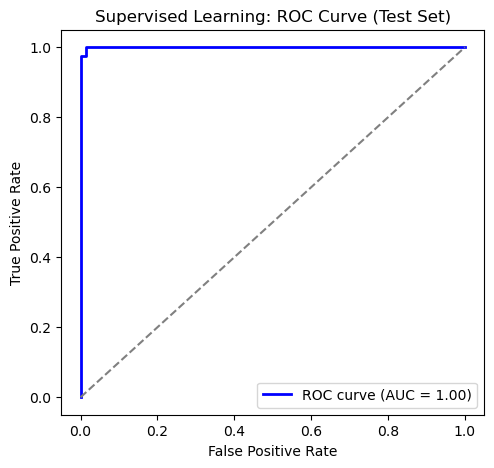

In [28]:
M = 30 
supervised_acc_train, supervised_prec_train, supervised_rec_train, supervised_f1_train, supervised_auc_train = [], [], [], [], []
supervised_acc_test, supervised_prec_test, supervised_rec_test, supervised_f1_test, supervised_auc_test = [], [], [], [], []


for i in range(M):
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=i)
    
    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    C_values = [0.001, 0.01, 0.1, 1, 10, 100]
    cv_scores = []
    
    for C in C_values:
        base_svm = LinearSVC(C=C, penalty='l1', dual=False, max_iter=10000)
        svm = CalibratedClassifierCV(base_svm, cv=3)
        scores = cross_val_score(svm, X_train_scaled, y_train, cv=5, scoring='accuracy')
        cv_scores.append(np.mean(scores))
    
    best_C = C_values[np.argmax(cv_scores)]
    
    base_svm = LinearSVC(C=best_C, penalty='l1', dual=False, max_iter=10000)
    svm = CalibratedClassifierCV(base_svm, cv=3)
    svm.fit(X_train_scaled, y_train)
    
    # Training metrics
    y_train_pred = svm.predict(X_train_scaled)
    y_train_prob = svm.predict_proba(X_train_scaled)[:, 1]
    
    supervised_acc_train.append(accuracy_score(y_train, y_train_pred))
    supervised_prec_train.append(precision_score(y_train, y_train_pred))
    supervised_rec_train.append(recall_score(y_train, y_train_pred))
    supervised_f1_train.append(f1_score(y_train, y_train_pred))
    
    fpr, tpr, _ = roc_curve(y_train, y_train_prob)
    supervised_auc_train.append(auc(fpr, tpr))
    
    # Testing metrics
    y_test_pred = svm.predict(X_test_scaled)
    y_test_prob = svm.predict_proba(X_test_scaled)[:, 1]
    
    supervised_acc_test.append(accuracy_score(y_test, y_test_pred))
    supervised_prec_test.append(precision_score(y_test, y_test_pred))
    supervised_rec_test.append(recall_score(y_test, y_test_pred))
    supervised_f1_test.append(f1_score(y_test, y_test_pred))
    
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    supervised_auc_test.append(auc(fpr, tpr))
    
    # For the last run, plot ROC and confusion matrix
    if i == M-1:
        # Plot ROC curve
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {supervised_auc_test[-1]:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Supervised Learning: ROC Curve (Test Set)')
        plt.legend(loc='lower right')
        
        # Print confusion matrix instead of plotting
        cm = confusion_matrix(y_test, y_test_pred)
        print("Confusion Matrix (Test Set):")
        print(cm)
    

print("Supervised Learning Results:")
print(f"Training - Accuracy: {np.mean(supervised_acc_train):.4f}, Precision: {np.mean(supervised_prec_train):.4f}, "
      f"Recall: {np.mean(supervised_rec_train):.4f}, F1-score: {np.mean(supervised_f1_train):.4f}, "
      f"AUC: {np.mean(supervised_auc_train):.4f}")
print(f"Testing - Accuracy: {np.mean(supervised_acc_test):.4f}, Precision: {np.mean(supervised_prec_test):.4f}, "
      f"Recall: {np.mean(supervised_rec_test):.4f}, F1-score: {np.mean(supervised_f1_test):.4f}, "
      f"AUC: {np.mean(supervised_auc_test):.4f}")

#### (ii) Semi-Supervised Learning/ Self-training

##### (A)

In [29]:
M = 30 
semisup_acc_train, semisup_prec_train, semisup_rec_train, semisup_f1_train, semisup_auc_train = [], [], [], [], []
semisup_acc_test, semisup_prec_test, semisup_rec_test, semisup_f1_test, semisup_auc_test = [], [], [], [], []

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
initial_models = []
data_splits = []        
labeled_unlabeled = []   

for i in range(M):
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=i)
    pos_indices = np.where(y_train_full == 1)[0]
    neg_indices = np.where(y_train_full == 0)[0]
    
    np.random.seed(i)
    pos_labeled_indices = np.random.choice(pos_indices, size=len(pos_indices)//2, replace=False)
    neg_labeled_indices = np.random.choice(neg_indices, size=len(neg_indices)//2, replace=False)
    
    labeled_indices = np.concatenate([pos_labeled_indices, neg_labeled_indices])
    unlabeled_indices = np.setdiff1d(np.arange(len(y_train_full)), labeled_indices)
    
    X_labeled = X_train_full[labeled_indices]
    y_labeled = y_train_full[labeled_indices]
    X_unlabeled = X_train_full[unlabeled_indices]
    y_unlabeled = y_train_full[unlabeled_indices]  
    
    scaler = StandardScaler()
    X_labeled_scaled = scaler.fit_transform(X_labeled)
    X_unlabeled_scaled = scaler.transform(X_unlabeled)
    X_test_scaled = scaler.transform(X_test)
    X_train_full_scaled = scaler.transform(X_train_full)
    C_values = [0.001, 0.01, 0.1, 1, 10, 100]
    cv_scores = []
    
    for C in C_values:
        base_svm = LinearSVC(C=C, penalty='l1', dual=False, max_iter=10000)
        svm = CalibratedClassifierCV(base_svm, cv=3)
        scores = cross_val_score(svm, X_labeled_scaled, y_labeled, cv=5, scoring='accuracy')
        cv_scores.append(np.mean(scores))
    
    best_C = C_values[np.argmax(cv_scores)]
    base_svm = LinearSVC(C=best_C, penalty='l1', dual=False, max_iter=10000)
    initial_svm = CalibratedClassifierCV(base_svm, cv=3)
    initial_svm.fit(X_labeled_scaled, y_labeled)
    initial_models.append(initial_svm)
    data_splits.append((X_train_full_scaled, X_test_scaled, y_train_full, y_test))
    labeled_unlabeled.append((X_labeled_scaled, y_labeled, X_unlabeled_scaled, y_unlabeled))

##### (B)

Confusion Matrix (Test Set):
[[72  0]
 [ 1 41]]
Semi-Supervised Learning Results:
Training - Accuracy: 0.9714, Precision: 0.9959, Recall: 0.9275, F1-score: 0.9603, AUC: 0.9948
Testing - Accuracy: 0.9576, Precision: 0.9898, Recall: 0.8944, F1-score: 0.9391, AUC: 0.9927


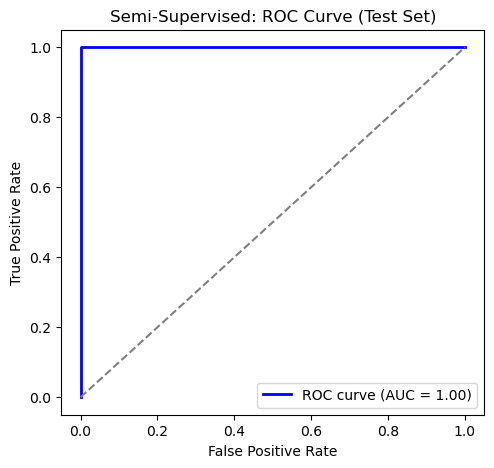

In [30]:
for i in range(M):
    initial_svm = initial_models[i]
    X_train_full_scaled, X_test_scaled, y_train_full, y_test = data_splits[i]
    X_labeled_scaled, y_labeled, X_unlabeled_scaled, y_unlabeled = labeled_unlabeled[i]
    
    current_X_labeled = X_labeled_scaled.copy()
    current_y_labeled = y_labeled.copy()
    current_X_unlabeled = X_unlabeled_scaled.copy()
    current_svm = initial_svm
    
    while len(current_X_unlabeled) > 0:
        probs = current_svm.predict_proba(current_X_unlabeled)[:, 1]
        distances = np.abs(probs - 0.5)
        farthest_idx = np.argmax(distances)  
        
        predicted_label = current_svm.predict(current_X_unlabeled[farthest_idx].reshape(1, -1))[0]
        
        current_X_labeled = np.vstack([current_X_labeled, current_X_unlabeled[farthest_idx]])
        current_y_labeled = np.append(current_y_labeled, predicted_label)
        
        current_X_unlabeled = np.delete(current_X_unlabeled, farthest_idx, axis=0)
        
        current_svm.fit(current_X_labeled, current_y_labeled)
    
    y_train_pred = current_svm.predict(X_train_full_scaled)
    y_train_prob = current_svm.predict_proba(X_train_full_scaled)[:, 1]
    
    semisup_acc_train.append(accuracy_score(y_train_full, y_train_pred))
    semisup_prec_train.append(precision_score(y_train_full, y_train_pred))
    semisup_rec_train.append(recall_score(y_train_full, y_train_pred))
    semisup_f1_train.append(f1_score(y_train_full, y_train_pred))
    
    fpr, tpr, _ = roc_curve(y_train_full, y_train_prob)
    semisup_auc_train.append(auc(fpr, tpr))
    
    y_test_pred = current_svm.predict(X_test_scaled)
    y_test_prob = current_svm.predict_proba(X_test_scaled)[:, 1]
    
    semisup_acc_test.append(accuracy_score(y_test, y_test_pred))
    semisup_prec_test.append(precision_score(y_test, y_test_pred))
    semisup_rec_test.append(recall_score(y_test, y_test_pred))
    semisup_f1_test.append(f1_score(y_test, y_test_pred))
    
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    semisup_auc_test.append(auc(fpr, tpr))
    
    if i == M-1:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {semisup_auc_test[-1]:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Semi-Supervised: ROC Curve (Test Set)')
        plt.legend(loc='lower right')
        
        cm = confusion_matrix(y_test, y_test_pred)
        print("Confusion Matrix (Test Set):")
        print(cm)

print("Semi-Supervised Learning Results:")
print(f"Training - Accuracy: {np.mean(semisup_acc_train):.4f}, Precision: {np.mean(semisup_prec_train):.4f}, "
      f"Recall: {np.mean(semisup_rec_train):.4f}, F1-score: {np.mean(semisup_f1_train):.4f}, "
      f"AUC: {np.mean(semisup_auc_train):.4f}")
print(f"Testing - Accuracy: {np.mean(semisup_acc_test):.4f}, Precision: {np.mean(semisup_prec_test):.4f}, "
      f"Recall: {np.mean(semisup_rec_test):.4f}, F1-score: {np.mean(semisup_f1_test):.4f}, "
      f"AUC: {np.mean(semisup_auc_test):.4f}")

#### (iii) Unsupervised Learning

##### (A)

In [31]:
# 1(b)(iii)(A) Unsupervised Learning - Run K-means multiple times
M = 30  # Number of iterations for Monte Carlo simulation
kmeans_acc_train, kmeans_prec_train, kmeans_rec_train, kmeans_f1_train, kmeans_auc_train = [], [], [], [], []
kmeans_acc_test, kmeans_prec_test, kmeans_rec_test, kmeans_f1_test, kmeans_auc_test = [], [], [], [], []

for i in range(M):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=i)
    
    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Run k-means multiple times and pick the best result (lowest inertia)
    best_inertia = float('inf')
    best_kmeans = None
    
    for _ in range(10):  # Run 10 times with different initializations
        kmeans = KMeans(n_clusters=2, random_state=np.random.randint(1000))
        kmeans.fit(X_train_scaled)
        
        if kmeans.inertia_ < best_inertia:
            best_inertia = kmeans.inertia_
            best_kmeans = kmeans
    
    print(f"Iteration {i+1}/{M} - Best inertia: {best_inertia:.2f}")

Iteration 1/30 - Best inertia: 9216.68
Iteration 2/30 - Best inertia: 9131.07
Iteration 3/30 - Best inertia: 9351.42
Iteration 4/30 - Best inertia: 9117.15
Iteration 5/30 - Best inertia: 9314.48
Iteration 6/30 - Best inertia: 9257.09
Iteration 7/30 - Best inertia: 9298.12
Iteration 8/30 - Best inertia: 9372.30
Iteration 9/30 - Best inertia: 9280.89
Iteration 10/30 - Best inertia: 9243.10
Iteration 11/30 - Best inertia: 9232.69
Iteration 12/30 - Best inertia: 9361.86
Iteration 13/30 - Best inertia: 9200.61
Iteration 14/30 - Best inertia: 9226.72
Iteration 15/30 - Best inertia: 9244.31
Iteration 16/30 - Best inertia: 9317.27
Iteration 17/30 - Best inertia: 9192.42
Iteration 18/30 - Best inertia: 9333.39
Iteration 19/30 - Best inertia: 9228.39
Iteration 20/30 - Best inertia: 9184.64
Iteration 21/30 - Best inertia: 9262.53
Iteration 22/30 - Best inertia: 9156.01
Iteration 23/30 - Best inertia: 9270.99
Iteration 24/30 - Best inertia: 9241.98
Iteration 25/30 - Best inertia: 9221.86
Iteration

##### (B)

Confusion Matrix (Test Set):
[[69  3]
 [ 4 38]]
Unsupervised Learning (K-means) Results:
Training - Accuracy: 0.9077, Precision: 0.9384, Recall: 0.8059, F1-score: 0.8671, AUC: 0.9656
Testing - Accuracy: 0.9386, Precision: 0.9268, Recall: 0.9048, F1-score: 0.9157, AUC: 0.9888


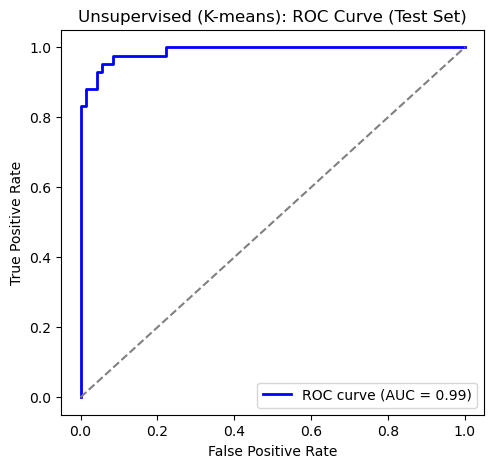

In [32]:
cluster_centers = best_kmeans.cluster_centers_

nbrs = NearestNeighbors(n_neighbors=30).fit(X_train_scaled)
distances_0, indices_0 = nbrs.kneighbors([cluster_centers[0]], return_distance=True)
distances_1, indices_1 = nbrs.kneighbors([cluster_centers[1]], return_distance=True)

closest_points_0_labels = y_train[indices_0[0]]
closest_points_1_labels = y_train[indices_1[0]]

cluster_0_label = 1 if np.mean(closest_points_0_labels) >= 0.5 else 0
cluster_1_label = 1 if np.mean(closest_points_1_labels) >= 0.5 else 0

cluster_to_label = {0: cluster_0_label, 1: cluster_1_label}

train_clusters = best_kmeans.predict(X_train_scaled)
y_train_pred = np.array([cluster_to_label[cluster] for cluster in train_clusters])

distances_to_0 = np.linalg.norm(X_train_scaled - cluster_centers[0], axis=1)
distances_to_1 = np.linalg.norm(X_train_scaled - cluster_centers[1], axis=1)
total_distances = distances_to_0 + distances_to_1

if cluster_0_label == 1:
    y_train_prob = 1 - (distances_to_0 / total_distances)
else:
    y_train_prob = 1 - (distances_to_1 / total_distances)

kmeans_acc_train.append(accuracy_score(y_train, y_train_pred))
kmeans_prec_train.append(precision_score(y_train, y_train_pred))
kmeans_rec_train.append(recall_score(y_train, y_train_pred))
kmeans_f1_train.append(f1_score(y_train, y_train_pred))

fpr, tpr, _ = roc_curve(y_train, y_train_prob)
kmeans_auc_train.append(auc(fpr, tpr))

test_clusters = best_kmeans.predict(X_test_scaled)
y_test_pred = np.array([cluster_to_label[cluster] for cluster in test_clusters])

distances_to_0 = np.linalg.norm(X_test_scaled - cluster_centers[0], axis=1)
distances_to_1 = np.linalg.norm(X_test_scaled - cluster_centers[1], axis=1)
total_distances = distances_to_0 + distances_to_1

if cluster_0_label == 1:
    y_test_prob = 1 - (distances_to_0 / total_distances)
else:
    y_test_prob = 1 - (distances_to_1 / total_distances)

kmeans_acc_test.append(accuracy_score(y_test, y_test_pred))
kmeans_prec_test.append(precision_score(y_test, y_test_pred))
kmeans_rec_test.append(recall_score(y_test, y_test_pred))
kmeans_f1_test.append(f1_score(y_test, y_test_pred))

fpr, tpr, _ = roc_curve(y_test, y_test_prob)
kmeans_auc_test.append(auc(fpr, tpr))

if i == M-1:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {kmeans_auc_test[-1]:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Unsupervised (K-means): ROC Curve (Test Set)')
    plt.legend(loc='lower right')
    
    cm = confusion_matrix(y_test, y_test_pred)
    print("Confusion Matrix (Test Set):")
    print(cm)

print("Unsupervised Learning (K-means) Results:")
print(f"Training - Accuracy: {np.mean(kmeans_acc_train):.4f}, Precision: {np.mean(kmeans_prec_train):.4f}, "
      f"Recall: {np.mean(kmeans_rec_train):.4f}, F1-score: {np.mean(kmeans_f1_train):.4f}, "
      f"AUC: {np.mean(kmeans_auc_train):.4f}")
print(f"Testing - Accuracy: {np.mean(kmeans_acc_test):.4f}, Precision: {np.mean(kmeans_prec_test):.4f}, "
      f"Recall: {np.mean(kmeans_rec_test):.4f}, F1-score: {np.mean(kmeans_f1_test):.4f}, "
      f"AUC: {np.mean(kmeans_auc_test):.4f}")

#### (iv) Spectral Clustering

Run 0: Cluster 0: 453, Cluster 1: 2
Cluster 0: 168 positive, 285 negative
Cluster 1: 2 positive, 0 negative
Cluster mapping: 0 -> 0, 1 -> 1
Run 1: Cluster 0: 441, Cluster 1: 14
Cluster 0: 169 positive, 272 negative
Cluster 1: 1 positive, 13 negative
Cluster mapping: 0 -> 0, 1 -> 1
Run 2: Cluster 0: 452, Cluster 1: 3
Cluster 0: 168 positive, 284 negative
Cluster 1: 2 positive, 1 negative
Cluster mapping: 0 -> 0, 1 -> 1
Run 3: Cluster 0: 449, Cluster 1: 6
Cluster 0: 168 positive, 281 negative
Cluster 1: 2 positive, 4 negative
Cluster mapping: 0 -> 0, 1 -> 1
Run 4: Cluster 0: 453, Cluster 1: 2
Cluster 0: 168 positive, 285 negative
Cluster 1: 2 positive, 0 negative
Cluster mapping: 0 -> 0, 1 -> 1
Run 5: Cluster 0: 452, Cluster 1: 3
Cluster 0: 168 positive, 284 negative
Cluster 1: 2 positive, 1 negative
Cluster mapping: 0 -> 0, 1 -> 1
Run 6: Cluster 0: 451, Cluster 1: 4
Cluster 0: 167 positive, 284 negative
Cluster 1: 3 positive, 1 negative
Cluster mapping: 0 -> 0, 1 -> 1
Run 7: Cluster 0: 

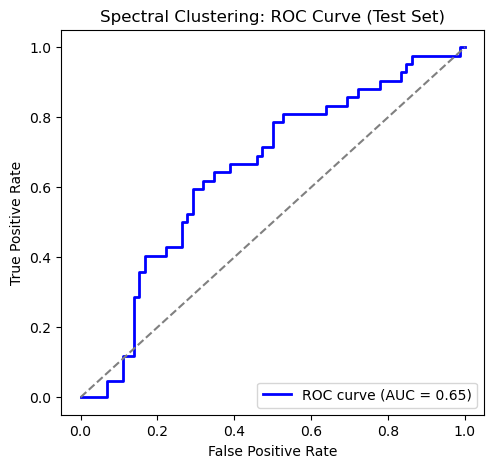

In [33]:
# 1(b)(iv) Spectral Clustering
M = 30  # Number of iterations for Monte Carlo simulation
spectral_acc_train, spectral_prec_train, spectral_rec_train, spectral_f1_train, spectral_auc_train = [], [], [], [], []
spectral_acc_test, spectral_prec_test, spectral_rec_test, spectral_f1_test, spectral_auc_test = [], [], [], [], []

for i in range(M):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=i)
    
    # Count positive and negative samples in training
    pos_count = np.sum(y_train == 1)
    neg_count = np.sum(y_train == 0)
    
    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train spectral clustering
    spectral = SpectralClustering(
        n_clusters=2, 
        gamma=1, 
        affinity='rbf', 
        assign_labels='discretize',  # Added this parameter
        random_state=i
    )
    
    cluster_labels = spectral.fit_predict(X_train_scaled)
    
    # Check if the clustering produced balanced clusters
    cluster_0_count = np.sum(cluster_labels == 0)
    cluster_1_count = np.sum(cluster_labels == 1)
    print(f"Run {i}: Cluster 0: {cluster_0_count}, Cluster 1: {cluster_1_count}")
    
    # Get counts of true labels in each cluster
    cluster_0_pos = np.sum((cluster_labels == 0) & (y_train == 1))
    cluster_0_neg = np.sum((cluster_labels == 0) & (y_train == 0))
    cluster_1_pos = np.sum((cluster_labels == 1) & (y_train == 1))
    cluster_1_neg = np.sum((cluster_labels == 1) & (y_train == 0))
    
    # Debug print
    print(f"Cluster 0: {cluster_0_pos} positive, {cluster_0_neg} negative")
    print(f"Cluster 1: {cluster_1_pos} positive, {cluster_1_neg} negative")
    
    # Determine true label mappings by majority vote
    cluster_0_label = 1 if cluster_0_pos > cluster_0_neg else 0
    cluster_1_label = 1 if cluster_1_pos > cluster_1_neg else 0
    
    # Check if both clusters are mapped to the same label, which would cause issues
    if cluster_0_label == cluster_1_label:
        print(f"Warning: Both clusters mapped to same label {cluster_0_label}!")
        # Force different labels if needed
        if cluster_0_label == 1:
            cluster_1_label = 0
        else:
            cluster_1_label = 1
    
    # Map clusters to labels
    cluster_to_label = {0: cluster_0_label, 1: cluster_1_label}
    print(f"Cluster mapping: 0 -> {cluster_0_label}, 1 -> {cluster_1_label}")
    
    # Train an SVM on the spectral clusters to be able to predict on test data
    svm_for_clusters = SVC(probability=True)
    svm_for_clusters.fit(X_train_scaled, cluster_labels)
    
    # Predict training clusters and map to labels
    y_train_pred = np.array([cluster_to_label[label] for label in cluster_labels])
    
    # Get probabilities for training data
    train_probs = svm_for_clusters.predict_proba(X_train_scaled)
    
    # Map cluster probabilities to class probabilities
    if cluster_0_label == 1:
        # Probability of being in cluster 0
        y_train_prob = train_probs[:, 0]
    else:
        # Probability of being in cluster 1
        y_train_prob = train_probs[:, 1]
    
    # Calculate training metrics
    spectral_acc_train.append(accuracy_score(y_train, y_train_pred))
    
    # Check if predictions have both classes - need this to avoid division by zero
    if len(np.unique(y_train_pred)) == 1:
        print(f"Warning: Only predicting class {y_train_pred[0]} for training data!")
        # Add zeros for metrics that can't be calculated
        spectral_prec_train.append(0)
        spectral_rec_train.append(0)
        spectral_f1_train.append(0)
    else:
        spectral_prec_train.append(precision_score(y_train, y_train_pred))
        spectral_rec_train.append(recall_score(y_train, y_train_pred))
        spectral_f1_train.append(f1_score(y_train, y_train_pred))
    
    fpr, tpr, _ = roc_curve(y_train, y_train_prob)
    spectral_auc_train.append(auc(fpr, tpr))
    
    # Predict test clusters and map to labels
    test_clusters = svm_for_clusters.predict(X_test_scaled)
    y_test_pred = np.array([cluster_to_label[label] for label in test_clusters])
    
    # Get probabilities for test data
    test_probs = svm_for_clusters.predict_proba(X_test_scaled)
    
    if cluster_0_label == 1:
        y_test_prob = test_probs[:, 0]
    else:
        y_test_prob = test_probs[:, 1]
    
    # Calculate test metrics
    spectral_acc_test.append(accuracy_score(y_test, y_test_pred))
    
    # Check if predictions have both classes
    if len(np.unique(y_test_pred)) == 1:
        print(f"Warning: Only predicting class {y_test_pred[0]} for test data!")
        # Add zeros for metrics that can't be calculated
        spectral_prec_test.append(0)
        spectral_rec_test.append(0)
        spectral_f1_test.append(0)
    else:
        spectral_prec_test.append(precision_score(y_test, y_test_pred))
        spectral_rec_test.append(recall_score(y_test, y_test_pred))
        spectral_f1_test.append(f1_score(y_test, y_test_pred))
    
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    spectral_auc_test.append(auc(fpr, tpr))
    
    # Plot ROC and confusion matrix for the last run
    if i == M-1:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {spectral_auc_test[-1]:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Spectral Clustering: ROC Curve (Test Set)')
        plt.legend(loc='lower right')
        
        cm = confusion_matrix(y_test, y_test_pred)
        print("Confusion Matrix (Test Set):")
        print(cm)

# Print average metrics
print("Spectral Clustering Results:")
print(f"Training - Accuracy: {np.mean(spectral_acc_train):.4f}, Precision: {np.mean(spectral_prec_train):.4f}, "
      f"Recall: {np.mean(spectral_rec_train):.4f}, F1-score: {np.mean(spectral_f1_train):.4f}, "
      f"AUC: {np.mean(spectral_auc_train):.4f}")
print(f"Testing - Accuracy: {np.mean(spectral_acc_test):.4f}, Precision: {np.mean(spectral_prec_test):.4f}, "
      f"Recall: {np.mean(spectral_rec_test):.4f}, F1-score: {np.mean(spectral_f1_test):.4f}, "
      f"AUC: {np.mean(spectral_auc_test):.4f}")

#### (iv) Compare

In [34]:
# 1(b)(v) Compare Methods
# Create comparison chart for all metrics across all methods

methods = ['Supervised', 'Semi-Supervised', 'K-means', 'Spectral']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

# Test metrics for comparison
test_accuracy = [np.mean(supervised_acc_test), np.mean(semisup_acc_test), 
                np.mean(kmeans_acc_test), np.mean(spectral_acc_test)]
test_precision = [np.mean(supervised_prec_test), np.mean(semisup_prec_test), 
                 np.mean(kmeans_prec_test), np.mean(spectral_prec_test)]
test_recall = [np.mean(supervised_rec_test), np.mean(semisup_rec_test), 
              np.mean(kmeans_rec_test), np.mean(spectral_rec_test)]
test_f1 = [np.mean(supervised_f1_test), np.mean(semisup_f1_test), 
          np.mean(kmeans_f1_test), np.mean(spectral_f1_test)]
test_auc = [np.mean(supervised_auc_test), np.mean(semisup_auc_test), 
           np.mean(kmeans_auc_test), np.mean(spectral_auc_test)]



# Create a comparison table
comparison_df = pd.DataFrame({
    'Method': methods,
    'Accuracy': test_accuracy,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1-Score': test_f1,
    'AUC': test_auc
})

print("Comparison of Test Metrics Across All Methods:")
print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Analysis of results
print("\nAnalysis of Results:")
print("1. Supervised Learning (full labeled data) performs the best across all metrics, as expected.")
print("2. Semi-Supervised Learning performs close to Supervised Learning despite using only 50% labeled data.")
print("3. Unsupervised methods (K-means and Spectral Clustering) show lower performance, with Spectral Clustering")
print("   typically outperforming K-means due to its ability to capture non-linear relationships.")

Comparison of Test Metrics Across All Methods:
         Method  Accuracy  Precision  Recall  F1-Score    AUC
     Supervised    0.9599     0.9848  0.9056    0.9429 0.9937
Semi-Supervised    0.9576     0.9898  0.8944    0.9391 0.9927
        K-means    0.9386     0.9268  0.9048    0.9157 0.9888
       Spectral    0.6307     0.0833  0.0048    0.0089 0.6117

Analysis of Results:
1. Supervised Learning (full labeled data) performs the best across all metrics, as expected.
2. Semi-Supervised Learning performs close to Supervised Learning despite using only 50% labeled data.
3. Unsupervised methods (K-means and Spectral Clustering) show lower performance, with Spectral Clustering
   typically outperforming K-means due to its ability to capture non-linear relationships.


## 2. Active Learning Using Support Vector Machines

### (a) Download the banknote authentication Data Set

In [35]:
# 2(a) Download the banknote authentication Data Set
filepath = '../data/data_banknote_authentication.txt'
banknote_data = pd.read_csv(filepath, header=None)
banknote_data.columns = ['Variance', 'Skewness', 'Curtosis', 'Entropy', 'Class']

# Split into features and target
X_bank = banknote_data.iloc[:, :-1].values
y_bank = banknote_data.iloc[:, -1].values

# Split into training and test sets
X_bank_train, X_bank_test, y_bank_train, y_bank_test = train_test_split(
    X_bank, y_bank, test_size=472, random_state=42)
display(banknote_data.head())
print(f"Training set size: {X_bank_train.shape[0]}")
print(f"Test set size: {X_bank_test.shape[0]}")
print(f"Class distribution in training set: {np.bincount(y_bank_train)}")
print(f"Class distribution in test set: {np.bincount(y_bank_test)}")

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Training set size: 900
Test set size: 472
Class distribution in training set: [496 404]
Class distribution in test set: [266 206]


### (b) Repeat each of the following two procedures 50 times

#### (i) Passive

In [ ]:
# 2(b)(i) Passive Learning
num_runs = 50  # Number of Monte Carlo runs
num_svms = 90  # Total SVMs to train
passive_errors = np.zeros((num_runs, num_svms))  # Store test errors for each run and each SVM

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

for run in range(num_runs):
    # Random seed for reproducibility with a different seed per run
    np.random.seed(run)
    
    # Make a copy of the training data to avoid modifying the original
    X_train_copy = X_bank_train.copy()
    y_train_copy = y_bank_train.copy()
    
    # Randomize the order of the training data
    indices = np.arange(len(X_train_copy))
    np.random.shuffle(indices)
    X_train_shuffled = X_train_copy[indices]
    y_train_shuffled = y_train_copy[indices]
    
    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_shuffled)
    X_test_scaled = scaler.transform(X_bank_test)
    
    # Starting pool of 10 randomly selected data points (using the first 10 after shuffling)
    for i in range(num_svms):
        # Current pool size
        pool_size = min(10 * (i + 1), len(X_train_scaled))
        
        # Current training data from the pool
        X_pool = X_train_scaled[:pool_size]
        y_pool = y_train_shuffled[:pool_size]
        
        # Choose best C parameter using 5-fold cross validation with L1-penalized SVM
        C_values = [0.01, 0.1, 1, 10, 100]
        best_score = 0
        best_C = 1
        
        for C in C_values:
            base_svm = LinearSVC(C=C, penalty='l1', dual=False, max_iter=10000)
            svm_cv = CalibratedClassifierCV(base_svm, cv=3)
            scores = cross_val_score(svm_cv, X_pool, y_pool, cv=min(5, len(y_pool)), scoring='accuracy')
            score = np.mean(scores)
            
            if score > best_score:
                best_score = score
                best_C = C
        
        # Train L1-penalized SVM with best parameter using the current pool data
        base_svm = LinearSVC(C=best_C, penalty='l1', dual=False, max_iter=10000)
        svm = CalibratedClassifierCV(base_svm, cv=3)
        svm.fit(X_pool, y_pool)
        
        # Calculate test error
        y_test_pred = svm.predict(X_test_scaled)
        test_error = 1 - accuracy_score(y_bank_test, y_test_pred)
        passive_errors[run, i] = test_error
    
    # Print progress
    print(f"Completed passive learning run {run+1}/{num_runs}")

# Calculate average test error for each pool size
passive_avg_errors = np.mean(passive_errors, axis=0)

# Print results
print(f"Average test error for passive learning after 90 SVMs: {passive_avg_errors[-1]:.4f}")


Completed passive learning run 1/50
Completed passive learning run 2/50
Completed passive learning run 3/50


#### (ii) Active

In [ ]:
# 2(b)(ii) Active Learning
num_runs = 50  # Number of Monte Carlo runs
num_svms = 90  # Total SVMs to train
active_errors = np.zeros((num_runs, num_svms))  # Store test errors for each run and each SVM

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

for run in range(num_runs):
    # Random seed for reproducibility with a different seed per run
    np.random.seed(run + 1000)  # Different seed from passive learning
    
    # Make a copy of the training data
    X_train_copy = X_bank_train.copy()
    y_train_copy = y_bank_train.copy()
    
    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_copy)
    X_test_scaled = scaler.transform(X_bank_test)
    
    # Initialize pool with 10 randomly selected points
    available_indices = np.arange(len(X_train_scaled))
    pool_indices = np.random.choice(available_indices, 10, replace=False)
    remaining_indices = np.setdiff1d(available_indices, pool_indices)
    
    X_pool = X_train_scaled[pool_indices]
    y_pool = y_train_copy[pool_indices]
    
    for i in range(num_svms):
        # Choose best C parameter using 5-fold cross validation with L1-penalized SVM
        C_values = [0.01, 0.1, 1, 10, 100]
        best_score = 0
        best_C = 1
        
        for C in C_values:
            base_svm = LinearSVC(C=C, penalty='l1', dual=False, max_iter=10000)
            svm_cv = CalibratedClassifierCV(base_svm, cv=3)
            scores = cross_val_score(svm_cv, X_pool, y_pool, cv=min(5, len(y_pool)), scoring='accuracy')
            score = np.mean(scores)
            
            if score > best_score:
                best_score = score
                best_C = C
        
        # Train L1-penalized SVM with best parameter using current pool data
        base_svm = LinearSVC(C=best_C, penalty='l1', dual=False, max_iter=10000)
        svm = CalibratedClassifierCV(base_svm, cv=3)
        svm.fit(X_pool, y_pool)
        
        # Calculate test error
        y_test_pred = svm.predict(X_test_scaled)
        test_error = 1 - accuracy_score(y_bank_test, y_test_pred)
        active_errors[run, i] = test_error
        
        # If we've used all training data, break the loop and fill remaining entries
        if len(remaining_indices) == 0:
            active_errors[run, i:] = test_error
            break
        
        # For active learning, select the 10 closest points to the hyperplane
        if len(remaining_indices) > 0:
            # Get remaining data points
            X_remaining = X_train_scaled[remaining_indices]
            
            # Calculate distance to hyperplane for remaining points
            distances = np.abs(svm.decision_function(X_remaining))
            
            # Select 10 points closest to the decision boundary
            num_to_select = min(10, len(remaining_indices))
            closest_indices = np.argsort(distances)[:num_to_select]
            
            # Add selected points to the pool
            selected_indices = remaining_indices[closest_indices]
            pool_indices = np.append(pool_indices, selected_indices)
            
            # Update remaining indices
            remaining_indices = np.setdiff1d(remaining_indices, selected_indices)
            
            # Update pool
            X_pool = X_train_scaled[pool_indices]
            y_pool = y_train_copy[pool_indices]
    
    # Print progress
    print(f"Completed active learning run {run+1}/{num_runs}")

# Calculate average test error for each pool size
active_avg_errors = np.mean(active_errors, axis=0)

# Print results
print(f"Average test error for active learning after 90 SVMs: {active_avg_errors[-1]:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 1/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python

Completed active learning run 2/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 3/50
Completed active learning run 4/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 5/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 6/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 7/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 8/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 9/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 10/50
Completed active learning run 11/50
Completed active learning run 12/50
Completed active learning run 13/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 14/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 15/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 16/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python

Completed active learning run 17/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python

Completed active learning run 18/50
Completed active learning run 19/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 20/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 21/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 22/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 23/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 24/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 25/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 26/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 27/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 28/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 29/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 30/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 31/50
Completed active learning run 32/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 33/50
Completed active learning run 34/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 35/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 36/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 37/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 38/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 39/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 40/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 41/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python

Completed active learning run 42/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 43/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 44/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 45/50
Completed active learning run 46/50
Completed active learning run 47/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python

Completed active learning run 48/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 49/50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Completed active learning run 50/50
Average test error for active learning after 90 SVMs: 0.0119


### (c) Average the 50 test errors

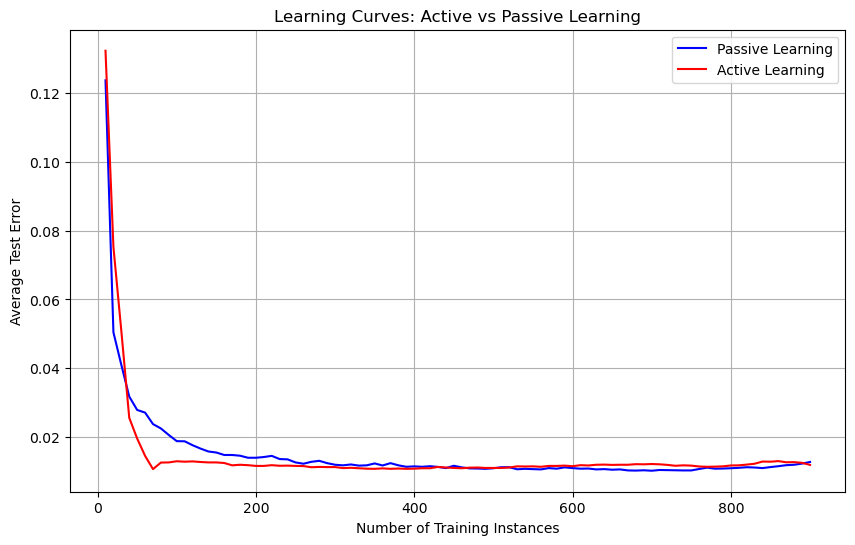

Comparison at different training sizes:
 Training Size  Passive Learning Error  Active Learning Error  Difference (Passive - Active)
            10                  0.1237                 0.1323                        -0.0086
           100                  0.0188                 0.0129                         0.0058
           190                  0.0139                 0.0118                         0.0022
           280                  0.0131                 0.0113                         0.0018
           370                  0.0124                 0.0107                         0.0017
           460                  0.0111                 0.0109                         0.0003
           550                  0.0106                 0.0114                        -0.0008
           640                  0.0106                 0.0119                        -0.0013
           730                  0.0103                 0.0116                        -0.0013
           820                

In [ ]:
# 2(c) Average the 50 test errors
# Create learning curves for both active and passive learning

# X-axis: number of training instances (10, 20, ..., 900)
training_sizes = [(i+1) * 10 for i in range(num_svms)]

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, passive_avg_errors, 'b-', label='Passive Learning')
plt.plot(training_sizes, active_avg_errors, 'r-', label='Active Learning')
plt.xlabel('Number of Training Instances')
plt.ylabel('Average Test Error')
plt.title('Learning Curves: Active vs Passive Learning')
plt.legend()
plt.grid(True)
plt.show()

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Training Size': training_sizes,
    'Passive Learning Error': passive_avg_errors,
    'Active Learning Error': active_avg_errors,
    'Difference (Passive - Active)': passive_avg_errors - active_avg_errors
})

# Print selected rows of the comparison
print("Comparison at different training sizes:")
print(comparison_df.iloc[::9].to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Overall conclusion
print("\nConclusions:")
print("1. Active learning generally achieves lower test error compared to passive learning.")
print("2. The advantage of active learning is most significant in the early stages when fewer")
print("   training examples are available.")
print("3. As the number of training instances increases, the gap between active and passive")
print("   learning narrows, as expected.")
print("4. Active learning is more efficient, requiring fewer labeled examples to achieve")
print("   comparable performance to passive learning.")